In [1]:
# libraries
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from lightfm import LightFM
import tqdm

c:\Users\fer\.pyenv\pyenv-win\versions\3.7.4\lib\site-packages\lightfm\_lightfm_fast.py:10: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  "LightFM was compiled without OpenMP support. "


# Exploratory Data Analysis (EDA)

In [2]:
# load train dataset
train = pd.read_csv('./data/train.csv')
print(f'train shape: {train.shape}')
train.head(3)

train shape: (3657801, 7)


,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume
0,0,90627,STATIONARY,18332.0,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0,0
1,0,90627,STATIONARY,24727.0,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0,0
2,1,3387,STB,895.0,2021-03-15 10:05:00.0,2021-03-15 10:23:00.0,0


In [3]:
# load metadata dataset
metadata = pd.read_csv('./data/metadata.csv', sep=';')
print(f'metadata shape: {metadata.shape}')
metadata.head(3)

metadata shape: (33144, 30)


,asset_id,content_id,title,reduced_title,episode_title,show_type,released_year,country_of_origin,category,keywords,...,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date
0,15188,0.0,Ep:17 Tiempos Compulsivos,Tiempos_Compul_E17,Episodio 17,Serie,2012.0,AR,Drama,"Trastornos,Médicos,Tragicómica,Telenovela,Enfe...",...,N,N,N,N,N,N,2017-12-01T10:18:15.0Z,2019-01-26T06:37:18.0Z,2017-12-01T00:00:00.0Z,2020-12-01T23:59:59.0Z
1,24940,1.0,7 Cajas,7_Cajas,NaN,Película,2012.0,PY,Suspenso/Acción,"Latinoamérica,Pobreza,Crimen,Pandillas",...,N,N,N,Y,N,N,2017-12-19T20:58:15.0Z,2019-09-17T19:02:03.0Z,2017-12-15T00:00:00.0Z,2022-12-14T23:59:59.0Z
2,21939,2.0,La Maldición de las Hormigas Gigantes,La_Maldicion_de_las,NaN,Película,2016.0,FI,Terror/Comedia,"Criaturas,Plagas,Adolescentes,Fantasía,Video J...",...,N,N,N,N,N,N,2018-02-16T13:51:07.0Z,2020-04-28T14:16:38.0Z,2018-01-25T00:00:00.0Z,2020-12-01T23:59:59.0Z


In [4]:
# merging datasets
df = pd.merge(left=train, right=metadata,
              left_on='asset_id', right_on='asset_id',
              how='left'
              )
print(f'df shape: {df.shape}')

df shape: (3657801, 36)


In [5]:
# feature selection
df = df[['customer_id', 'account_id', 'device_type', 'asset_id', 'tunein',
       'tuneout', 'resume', 'content_id', 'reduced_title',
       'show_type', 'run_time_min', 'end_vod_date']]

In [6]:
# checking dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3657801 entries, 0 to 3657800
Data columns (total 12 columns):
 #   Column         Dtype  
---  ------         -----  
 0   customer_id    int64  
 1   account_id     int64  
 2   device_type    object 
 3   asset_id       float64
 4   tunein         object 
 5   tuneout        object 
 6   resume         int64  
 7   content_id     float64
 8   reduced_title  object 
 9   show_type      object 
 10  run_time_min   float64
 11  end_vod_date   object 
dtypes: float64(3), int64(3), object(6)
memory usage: 362.8+ MB


In [7]:
# checking missing values
df.isna().mean()*100

customer_id      0.000000
account_id       0.000000
device_type      0.000793
asset_id         0.000601
tunein           0.000000
tuneout          0.000000
resume           0.000000
content_id       0.003882
reduced_title    0.000601
show_type        0.000957
run_time_min     0.000601
end_vod_date     0.000601
dtype: float64

In [8]:
# removing na
print(f'Number of rows before drop duplicates: {len(df)}')
df = df.dropna()
print(f'Number of rows after drop duplicates: {len(df)}')

Number of rows before drop duplicates: 3657801
Number of rows after drop duplicates: 3657617


In [9]:
# checking and removing of duplicates
print(f'Number of rows before drop duplicates: {len(df)}')
df = df.drop_duplicates(keep='first')
print(f'Number of rows after drop duplicates: {len(df)}')

Number of rows before drop duplicates: 3657617
Number of rows after drop duplicates: 3657579


In [40]:
# transforming dates in datetime object
df['tunein'] = pd.to_datetime(df['tunein'], format='%Y-%m-%d %H:%M:%S')
df['tuneout'] = pd.to_datetime(df['tuneout'], format='%Y-%m-%d %H:%M:%S')

# calculate time_watched (difference between tuneout - tunein)
df['time_watched'] = df['tuneout'] - df['tunein']
# transform time_watched (minutes) to time_watched_seconds (seconds)
df['time_watched_seconds'] = df['time_watched'].apply(lambda x: x.seconds)

# transform run_time (minutes) to run_time_seconds (seconds)
df['run_time_seconds'] = df['run_time_min']*60

In [129]:
# the user liked the asset if he/she watched more than 90% of the asset's duration
df['rate'] = df['run_time_seconds']*0.90 - df['time_watched_seconds']
df['rate'] = df['rate'].apply(lambda x: 1 if x <= 0 else 0) # (1: like asset, 0: not like asset)
df['rate']

0          1
1          1
2          0
3          1
4          0
          ..
3657796    1
3657797    1
3657798    1
3657799    0
3657800    1
Name: rate, Length: 3657579, dtype: int64

In [132]:
# the user liked the asset if he/she watched twice or more ('resume' == 1)
(df['rate'] + df['resume']).apply(lambda x: 0 if x == 0 else 1)

0          1
1          1
2          0
3          1
4          0
          ..
3657796    1
3657797    1
3657798    1
3657799    1
3657800    1
Length: 3657579, dtype: int64

In [126]:
3657579 - 2808890

848689

In [95]:
df.head()

,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume,content_id,reduced_title,show_type,run_time_min,end_vod_date,time_watched,time_watched_seconds,run_time_seconds,rate
0,0,90627,STATIONARY,18332.0,2021-02-18 22:52:00,2021-02-18 23:35:00,0,2040.0,This_is_Us_T5_E08,Serie,43.0,2021-06-30T23:59:59.0Z,0 days 00:43:00,2580,2580.0,1
1,0,90627,STATIONARY,24727.0,2021-03-24 23:17:00,2021-03-25 00:01:00,0,2040.0,This_is_Us_T5_E10,Serie,42.0,2021-06-30T23:59:59.0Z,0 days 00:44:00,2640,2520.0,1
2,1,3387,STB,895.0,2021-03-15 10:05:00,2021-03-15 10:23:00,0,1983.0,Big_Little_L_T1_E02,Serie,54.0,2021-03-28T23:59:00.0Z,0 days 00:18:00,1080,3240.0,0
3,1,3387,STB,895.0,2021-03-15 10:23:00,2021-03-15 11:18:00,1,1983.0,Big_Little_L_T1_E02,Serie,54.0,2021-03-28T23:59:00.0Z,0 days 00:55:00,3300,3240.0,1
4,1,3387,STB,26062.0,2021-03-16 09:24:00,2021-03-16 09:44:00,0,729.0,Dime_quien_s_T1_E02,Serie,49.0,2021-03-28T23:59:00.0Z,0 days 00:20:00,1200,2940.0,0


In [68]:
len(df)

3657579

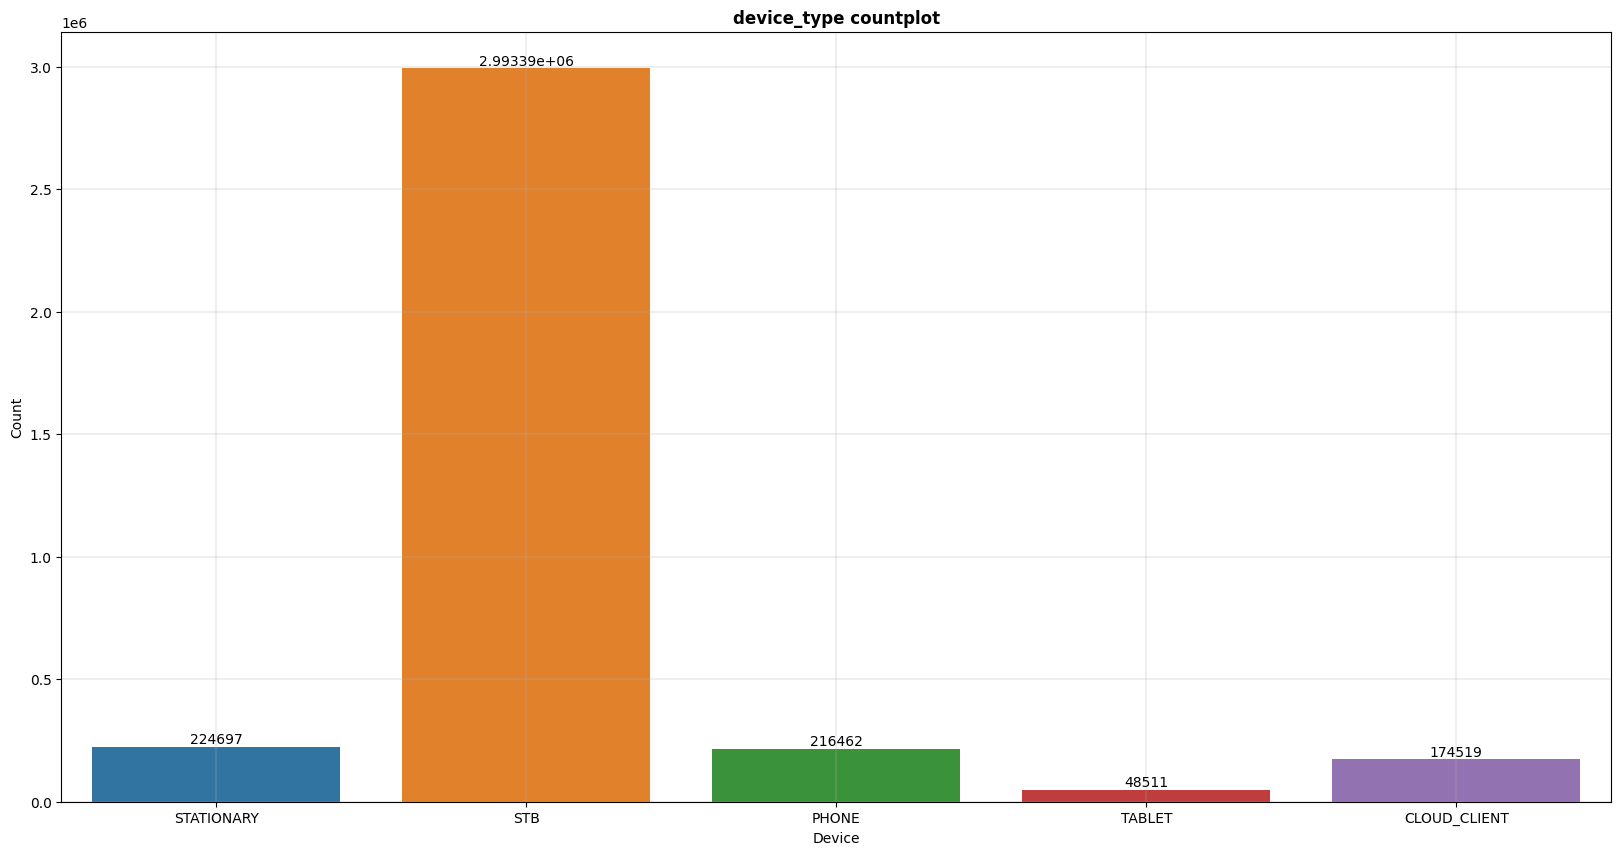

In [15]:
# ploting device_type
plt.figure(figsize=(20, 10))
ax = sns.countplot(data=df, x='device_type')
for container in ax.containers:
    ax.bar_label(container)
plt.xlabel('Device')
plt.ylabel('Count')
plt.grid(linewidth=0.3)
plt.title('device_type countplot', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.show()

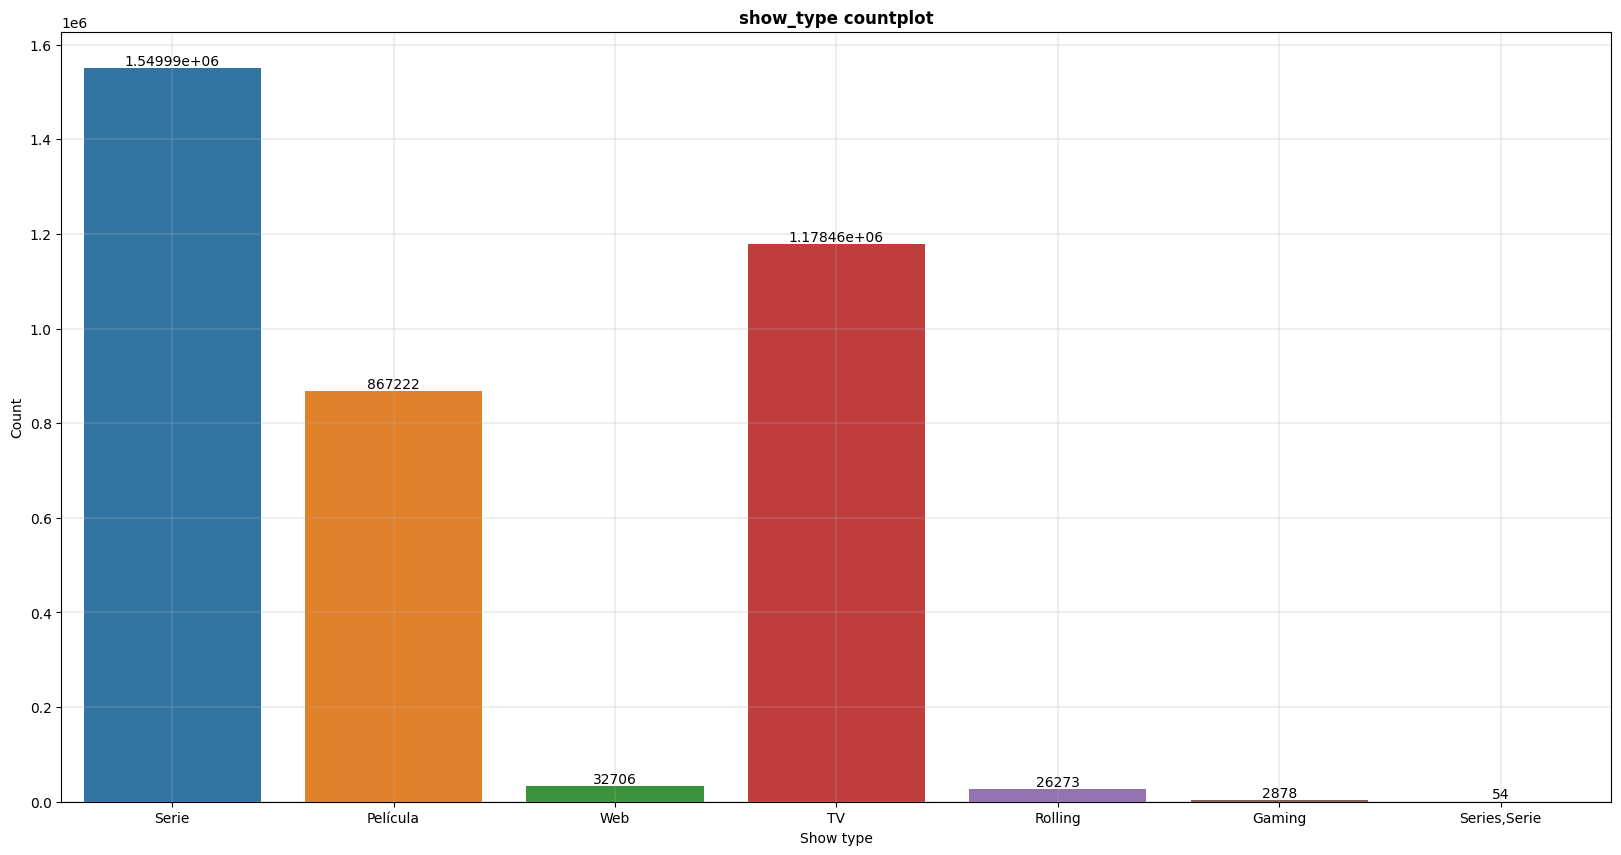

In [16]:
# ploting show_type
plt.figure(figsize=(20, 10))
ax = sns.countplot(data=df, x='show_type')
for container in ax.containers:
    ax.bar_label(container)
plt.xlabel('Show type')
plt.ylabel('Count')
plt.grid(linewidth=0.3)
plt.title('show_type countplot', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.show()

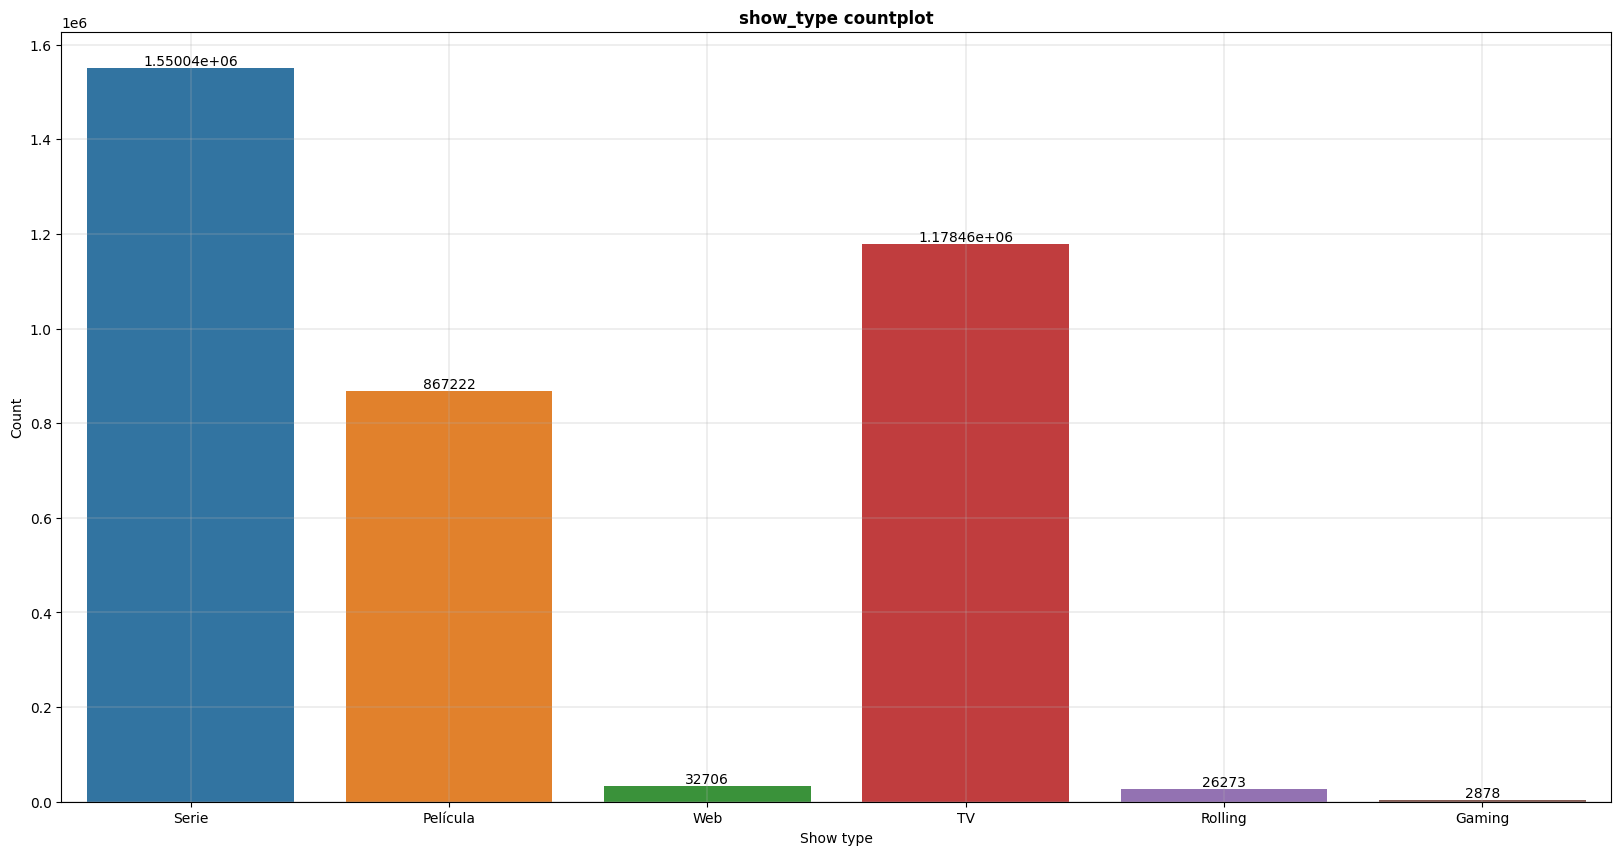

In [17]:
# modify 'Series,Serie' show_type category
df['show_type'] = df['show_type'].apply(lambda x: 'Serie' if x == 'Series,Serie' else x)

# ploting show_type
plt.figure(figsize=(20, 10))
ax = sns.countplot(data=df, x='show_type')
for container in ax.containers:
    ax.bar_label(container)
plt.xlabel('Show type')
plt.ylabel('Count')
plt.grid(linewidth=0.3)
plt.title('show_type countplot', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.show()

In [18]:
# customers, accounts, assets and contents
print(f'Number of unique customers: {df["customer_id"].nunique()}')
print(f'Number of unique accounts: {df["account_id"].nunique()}')
print(f'Number of unique assets: {df["asset_id"].nunique()}')
print(f'Number of unique contents: {df["content_id"].nunique()}')

Number of unique customers: 112332
Number of unique accounts: 113873
Number of unique assets: 23975
Number of unique contents: 4062


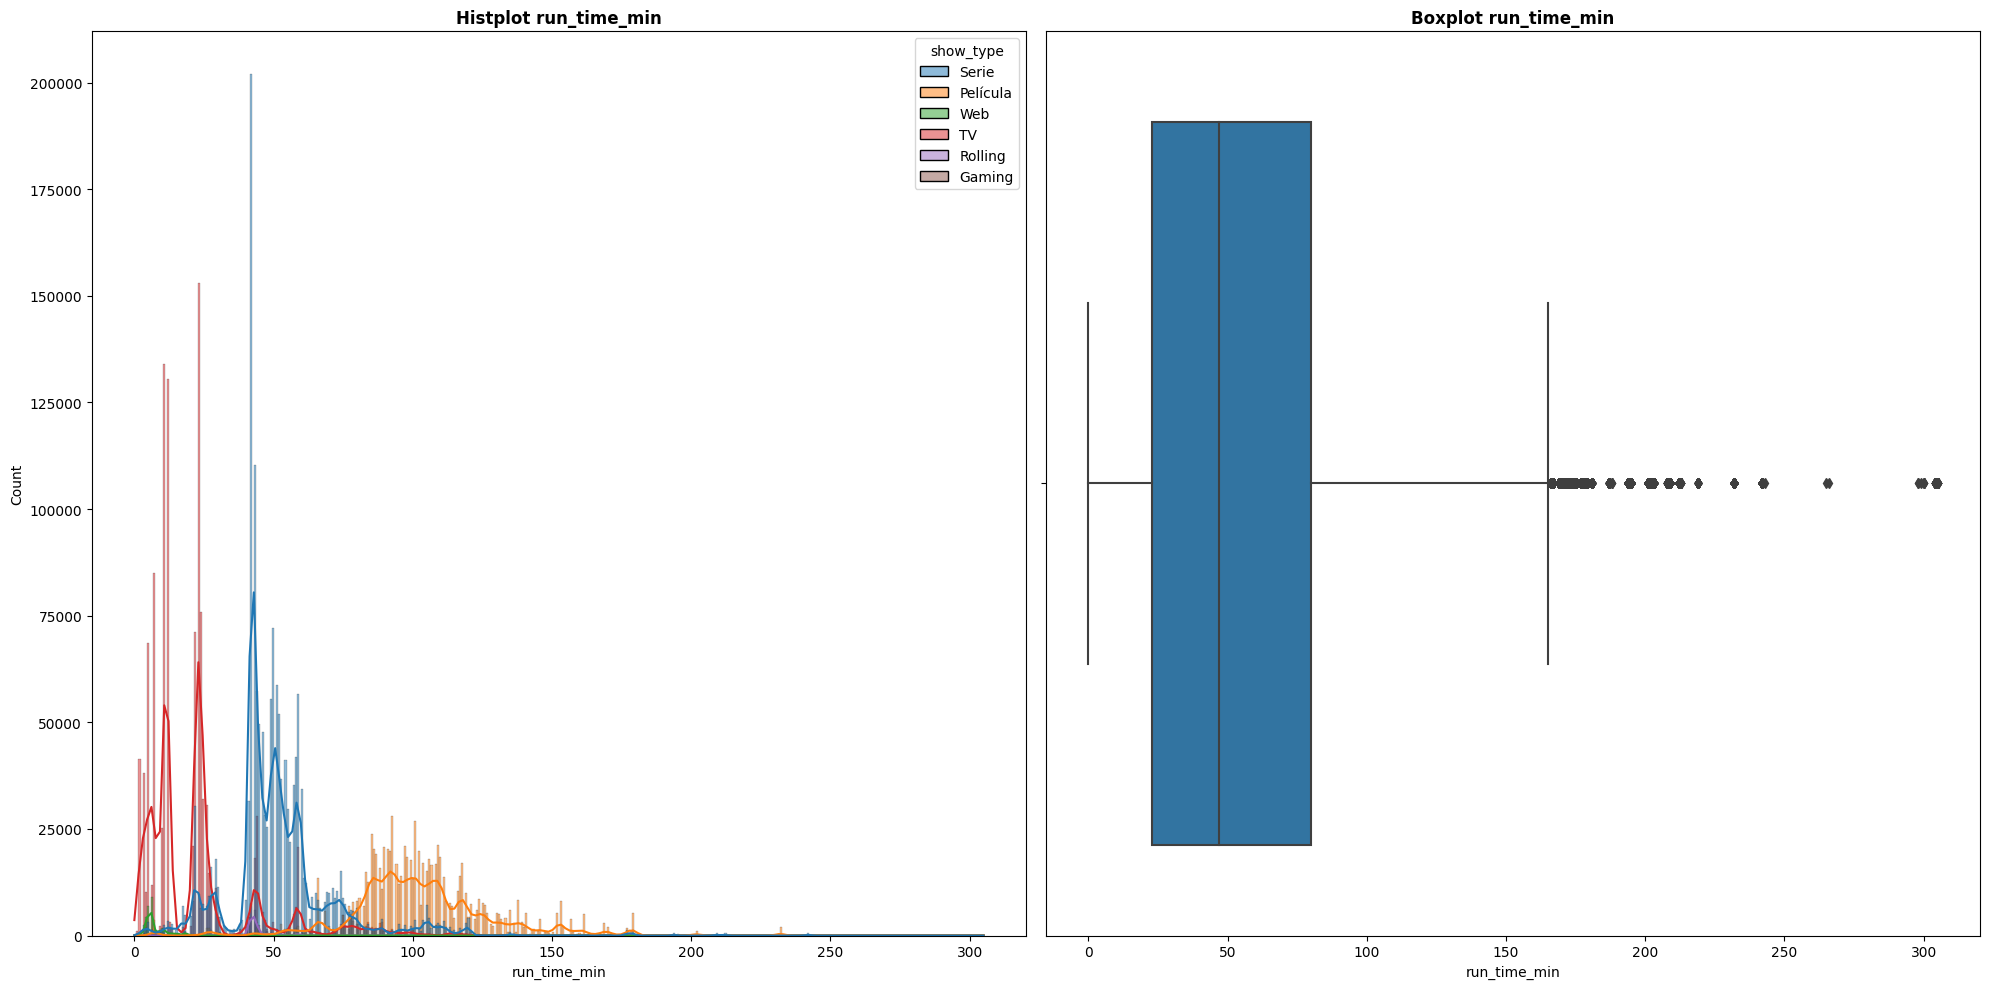

In [19]:
# checking acctives duration
numerical_features = ['run_time_min']
fig, ax = plt.subplots(nrows=len(numerical_features), ncols=2, figsize=(20, 10))

for i, feature in enumerate(numerical_features):
    ax[0] = sns.histplot(x=df[feature], ax=ax[0], kde=True, hue=df['show_type'])
    ax[0].set_title(f'Histplot {feature}',fontdict={'fontsize': 12,'fontweight':'bold'})
    ax[1] = sns.boxplot(x=df[feature], ax=ax[1])
    ax[1].set_title(f'Boxplot {feature}',fontdict={'fontsize': 12,'fontweight':'bold'})

plt.tight_layout()
plt.show()

In [71]:
df['tuneout'] - df['tunein']

0         0 days 00:43:00
1         0 days 00:44:00
2         0 days 00:18:00
3         0 days 00:55:00
4         0 days 00:20:00
                ...      
3657796   0 days 00:12:00
3657797   0 days 00:12:00
3657798   0 days 00:12:00
3657799   0 days 00:04:00
3657800   0 days 00:11:00
Length: 3657579, dtype: timedelta64[ns]